In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os

# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [2]:
import glob
import matplotlib.pyplot as plt
import cv2
from keras.preprocessing import image
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import MaxPooling2D, Dropout, UpSampling2D

Using TensorFlow backend.


In [4]:
from glob import glob
train_images = glob('kaggle/input/denoising-dirty-documents/train/*.png')
train_labels = glob('kaggle/input/denoising-dirty-documents/train_cleaned/*.png')
test_images = glob('kaggle/input/denoising-dirty-documents/test/*.png')
print("Total number of images in the training set: ", len(train_images))
print("Total number of cleaned images found: ", len(train_labels))
print("Total number of samples in the test set: ", len(test_images))

Total number of images in the training set:  144
Total number of cleaned images found:  144
Total number of samples in the test set:  72


### Sample of train images and train labels

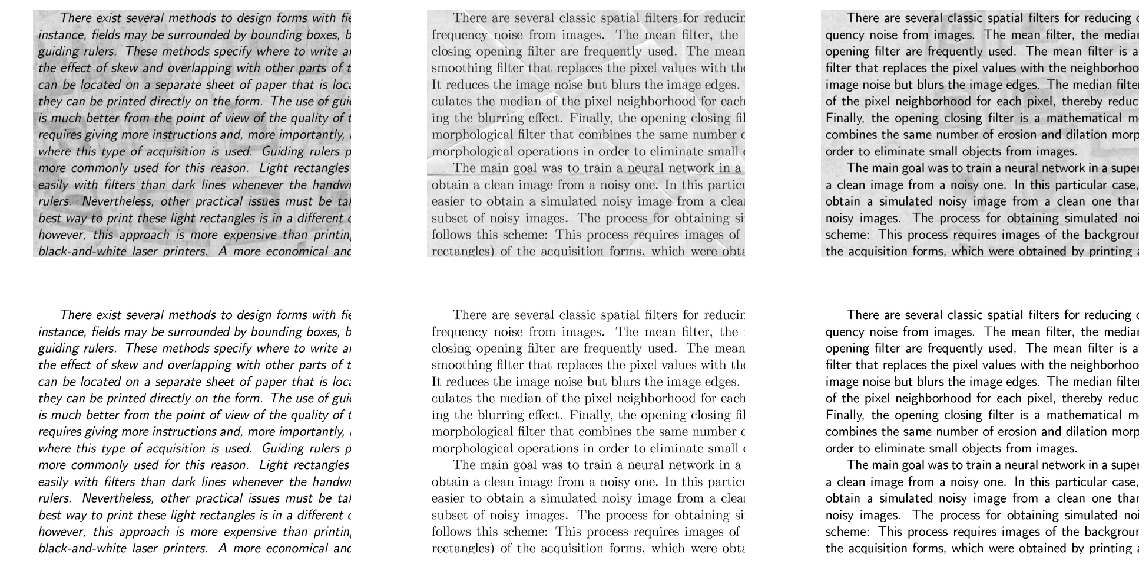

In [5]:
samples = train_images[:3] + train_labels[:3]

f, ax = plt.subplots(2,3,figsize = (20,10))
for i, img in enumerate(samples):
    img = cv2.imread(img)
    ax[i//3, i%3].imshow(img, cmap='gray')
    ax[i//3, i%3].axis('off')
plt.show()  

## CV2 Method

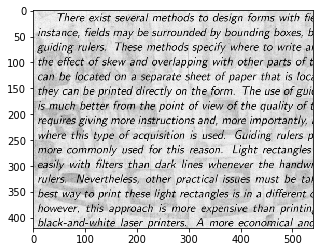

In [6]:
img = cv2.imread(train_images[0], cv2.IMREAD_GRAYSCALE)
plt.imshow(img,cmap = plt.cm.gray)
plt.show()

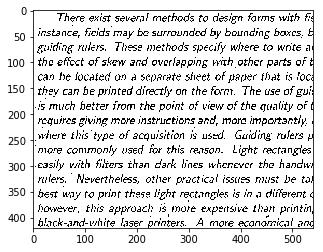

In [7]:
# applying different thresholding  
# techniques on the input image 
thresh1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 11, 30) 
plt.imshow(thresh1,cmap = plt.cm.gray) 
# plt.imshow(thresh2,cmap = plt.cm.gray) 
plt.show()

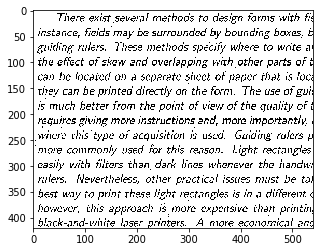

In [8]:
# applying different thresholding  
# techniques on the input image 
thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 25) 
plt.imshow(thresh2,cmap = plt.cm.gray) 
plt.show()

In [9]:
from PIL import Image
# cvt_image = cv2.cvtColor(thresh2, cv2.COLOR_GRAY2RGB)
im_pil = Image.fromarray(thresh2)
im_resized = im_pil.resize((540,420))
im_array = image.img_to_array(im_resized)

im_array.shape

(420, 540, 1)

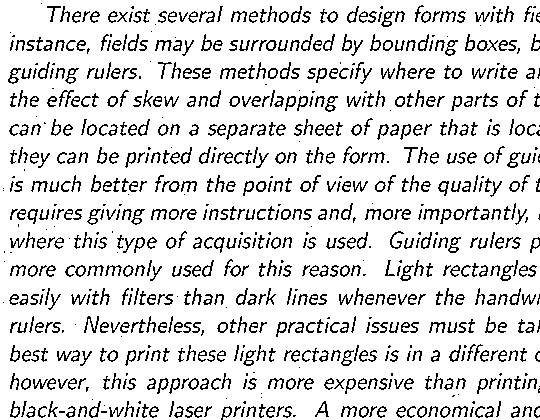

In [10]:
im_resized

In [11]:
proc_imgs = []
for k, figs in enumerate(zip(train_images, train_labels)):
    train_img = cv2.imread(figs[0], cv2.IMREAD_GRAYSCALE)
    proc_img = cv2.adaptiveThreshold(train_img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 25)
    
    # cvt_image = cv2.cvtColor(proc_img, cv2.COLOR_GRAY2RGB)
    im_pil = Image.fromarray(proc_img)
    im_resized = im_pil.resize((540,420))
    # plt.imshow(im_resized,cmap=plt.cm.gray)
    # plt.show()
    im_array = image.img_to_array(im_resized).astype('float32')/255
    
    proc_imgs.append(im_array)

## AutoEncoder

In [12]:
def AutoEncoder():
    input_img = Input(shape=(420,540,1), name = 'input_image')
    
    # Encoder Layer
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv1')(input_img)
    x = MaxPooling2D((2,2), padding='same', name='pool1')(x)
    
    # Decoder
    x = Conv2D(32, (3,3), activation='relu', padding='same', name='Conv2')(x)
    x = UpSampling2D((2,2), name='upsample3')(x)
    x = Conv2D(1, (3,3), activation='sigmoid', padding='same', name='Conv3')(x)
    
    ae = Model(inputs=input_img, outputs=x)
    ae.compile(optimizer='Adagrad', loss='binary_crossentropy')
    return ae

In [13]:
ae = AutoEncoder()
ae.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     (None, 420, 540, 1)       0         
_________________________________________________________________
Conv1 (Conv2D)               (None, 420, 540, 32)      320       
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 210, 270, 32)      0         
_________________________________________________________________
Conv2 (Conv2D)               (None, 210, 270, 32)      9248      
_________________________________________________________________
upsample3 (UpSampling2D)     (None, 420, 540, 32)      0         
_________________________________________________________________
Conv3 (Conv2D) 

In [14]:
X = []
Y = []

for img in train_images:
    img = image.load_img(img, color_mode='grayscale',target_size=(420,540))
    img = image.img_to_array(img).astype('float32')/255
    X.append(img)

for img in train_labels:
    img = image.load_img(img, color_mode='grayscale',target_size=(420,540))
    img = image.img_to_array(img).astype('float32')/255
    Y.append(img)


X = np.array(X)
Y = np.array(Y)

print("Size of X : ", X.shape)
print("Size of Y : ", Y.shape)

/Users/Elizabeth.Ke.Zhang/anaconda/lib/python3.7/site-packages/keras_preprocessing/image/utils.py:104: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn('grayscale is deprecated. Please use '


Size of X :  (144, 420, 540, 1)
Size of Y :  (144, 420, 540, 1)


In [15]:
from sklearn.model_selection import train_test_split
# Split the dataset into training and validation. Always set the random state!!
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size=0.2, random_state=100)
print("Total number of training samples: ", X_train.shape)
print("Total number of validation samples: ", X_valid.shape)

Total number of training samples:  (115, 420, 540, 1)
Total number of validation samples:  (29, 420, 540, 1)


In [16]:
# Train your model
ae.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))


Train on 115 samples, validate on 29 samples
Epoch 1/100
115/115 [==============================] - 66s 578ms/step - loss: 0.3365 - val_loss: 0.2541
Epoch 2/100
115/115 [==============================] - 43s 373ms/step - loss: 0.2151 - val_loss: 0.1845
Epoch 3/100
115/115 [==============================] - 43s 375ms/step - loss: 0.1737 - val_loss: 0.1648
Epoch 4/100
115/115 [==============================] - 52s 453ms/step - loss: 0.1589 - val_loss: 0.1601
Epoch 5/100
115/115 [==============================] - 47s 413ms/step - loss: 0.1516 - val_loss: 0.1507
Epoch 6/100
115/115 [==============================] - 43s 374ms/step - loss: 0.1438 - val_loss: 0.1460
Epoch 7/100
115/115 [==============================] - 45s 388ms/step - loss: 0.1401 - val_loss: 0.1463
Epoch 8/100
115/115 [==============================] - 47s 407ms/step - loss: 0.1370 - val_loss: 0.1429
Epoch 9/100
115/115 [==============================] - 49s 423ms/step - loss: 0.1358 - val_loss: 0.1401
Epoch 10/100
115/1

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/Elizabeth.Ke.Zhang/anaconda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-6b57ae059236>", line 2, in <module>
    ae.fit(X_train, y_train, epochs=100, batch_size=8, validation_data=(X_valid, y_valid))
  File "/Users/Elizabeth.Ke.Zhang/anaconda/lib/python3.7/site-packages/keras/engine/training.py", line 1239, in fit
    validation_freq=validation_freq)
  File "/Users/Elizabeth.Ke.Zhang/anaconda/lib/python3.7/site-packages/keras/engine/training_arrays.py", line 196, in fit_loop
    outs = fit_function(ins_batch)
  File "/Users/Elizabeth.Ke.Zhang/anaconda/lib/python3.7/site-packages/tensorflow_core/python/keras/backend.py", line 3476, in __call__
    run_metadata=self.run_metadata)
  File "/Users/Elizabeth.Ke.Zhang/anaconda/lib/python3.7/site-packages/tensorflow_core/python/client/session.py", line 1472, in __call__
    r

KeyboardInterrupt: 

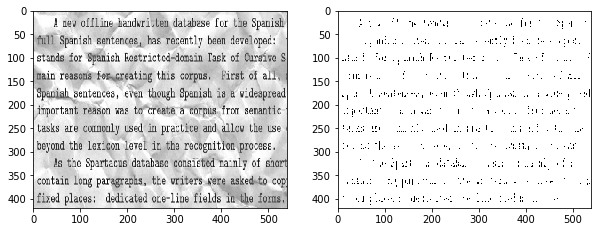

In [17]:
sample_test = image.load_img(test_images[10], color_mode='grayscale', target_size=(420,540))
sample_test = image.img_to_array(sample_test)
sample_test_img = sample_test.astype('float32')/255.
sample_test_img = np.expand_dims(sample_test, axis=0)

# Get the predition
predicted_label = np.squeeze(ae.predict(sample_test_img))

f, ax = plt.subplots(1,2, figsize=(10,8))
ax[0].imshow(np.squeeze(sample_test), cmap='gray')
ax[1].imshow(np.squeeze(predicted_label.astype('int8')), cmap='gray')
plt.show()